# 03 - Exploratory Data Analysis (EDA)

EDA más profundo: distribuciones, relaciones, correlaciones, heatmap y análisis por grupos. Usamos `train.csv` y `val.csv`.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("../data/processed")
train = pd.read_csv(DATA_DIR / 'train.csv')
val = pd.read_csv(DATA_DIR / 'val.csv')

# Concatenar para EDA general
_df = pd.concat([train, val], axis=0).reset_index(drop=True)
print('EDA dataset shape:', _df.shape)


EDA dataset shape: (750000, 9)


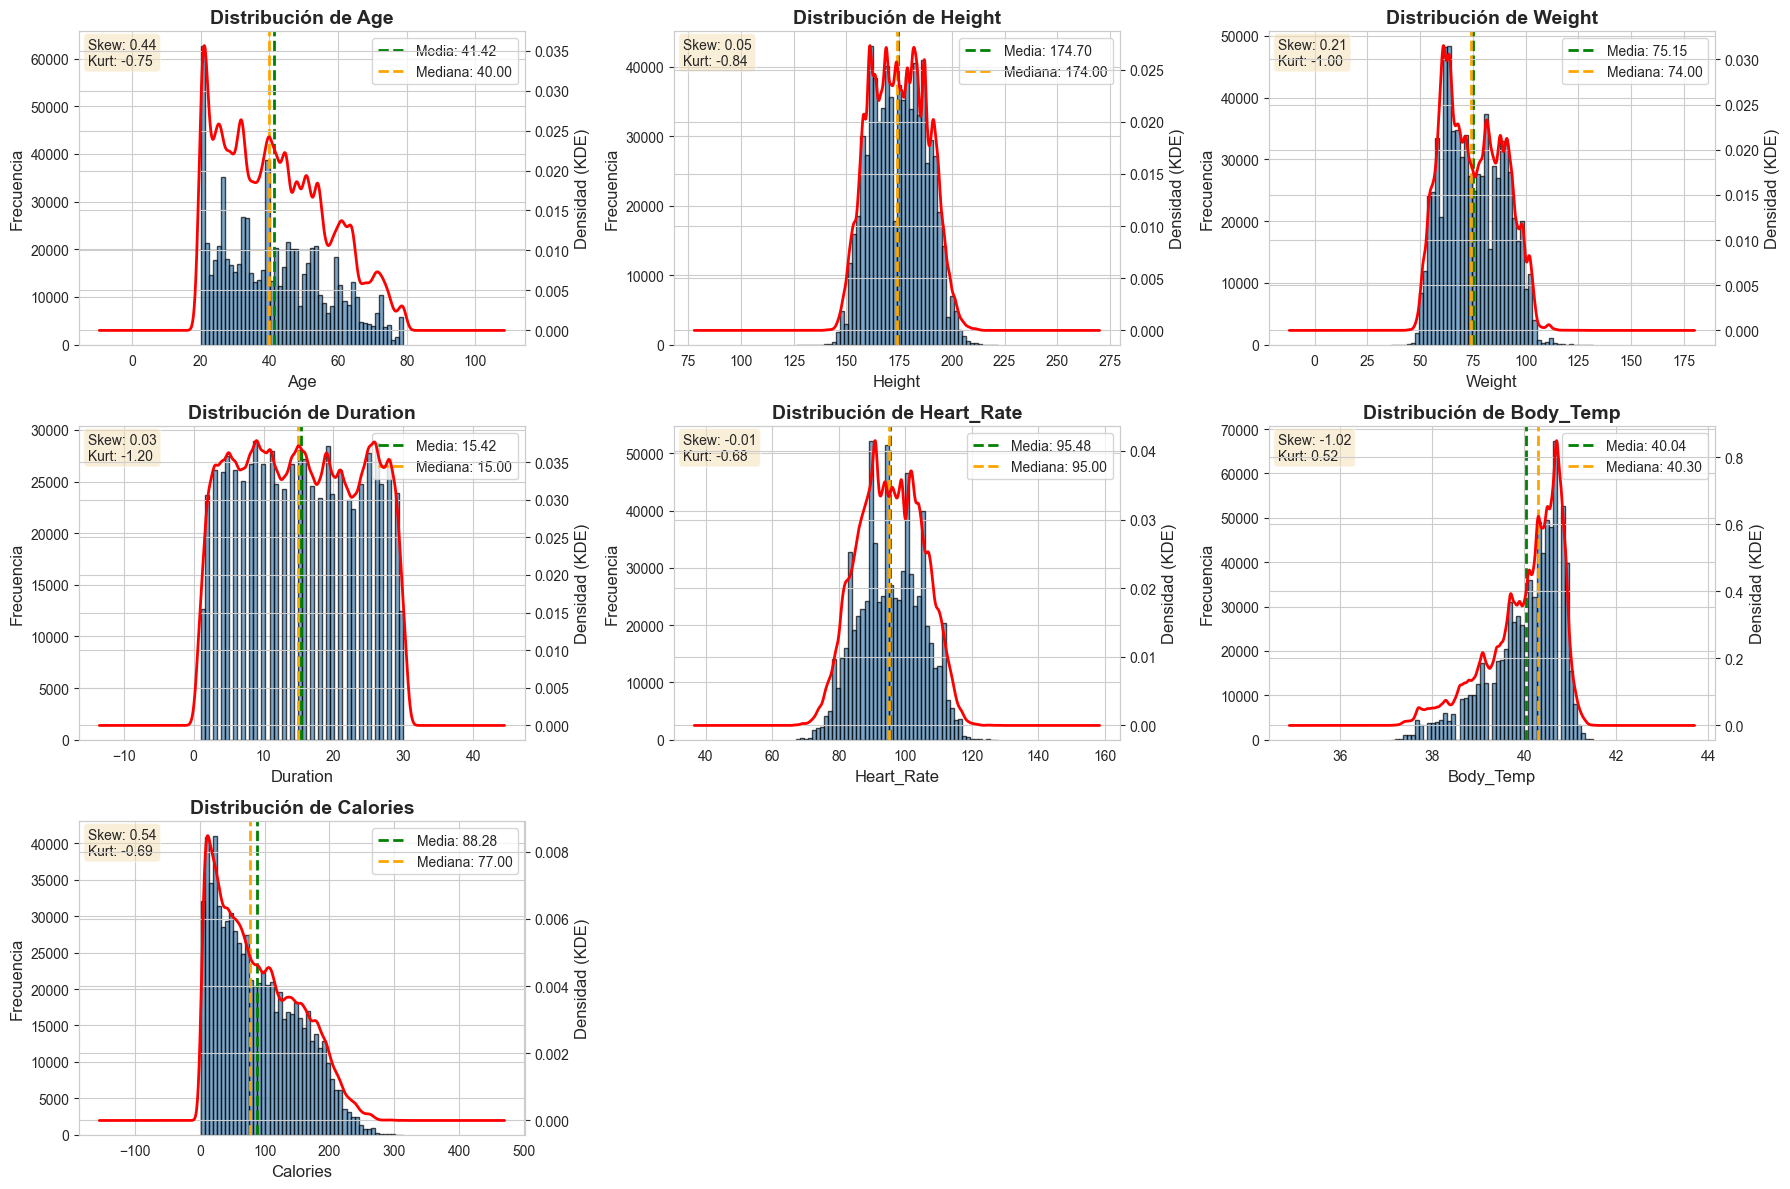

✅ Histogramas individuales guardados en: results/figures/histogramas_individuales.png


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Crear subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]

    # Histograma con KDE
    _df[col].hist(bins=50, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
    ax2 = ax.twinx()
    _df[col].plot(kind='kde', ax=ax2, color='red', linewidth=2)

    # Líneas de media y mediana
    mean_val = _df[col].mean()
    median_val = _df[col].median()
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')

    # Títulos y etiquetas
    ax.set_title(f'Distribución de {col}', fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax2.set_ylabel('Densidad (KDE)', fontsize=12)
    ax.legend(loc='upper right')

    # Agregar estadísticas en el gráfico
    skew = _df[col].skew()
    kurt = _df[col].kurtosis()
    ax.text(0.02, 0.98, f'Skew: {skew:.2f}\nKurt: {kurt:.2f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Eliminar ejes vacíos
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('../results/figures/histogramas_individuales.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Histogramas individuales guardados en: results/figures/histogramas_individuales.png")

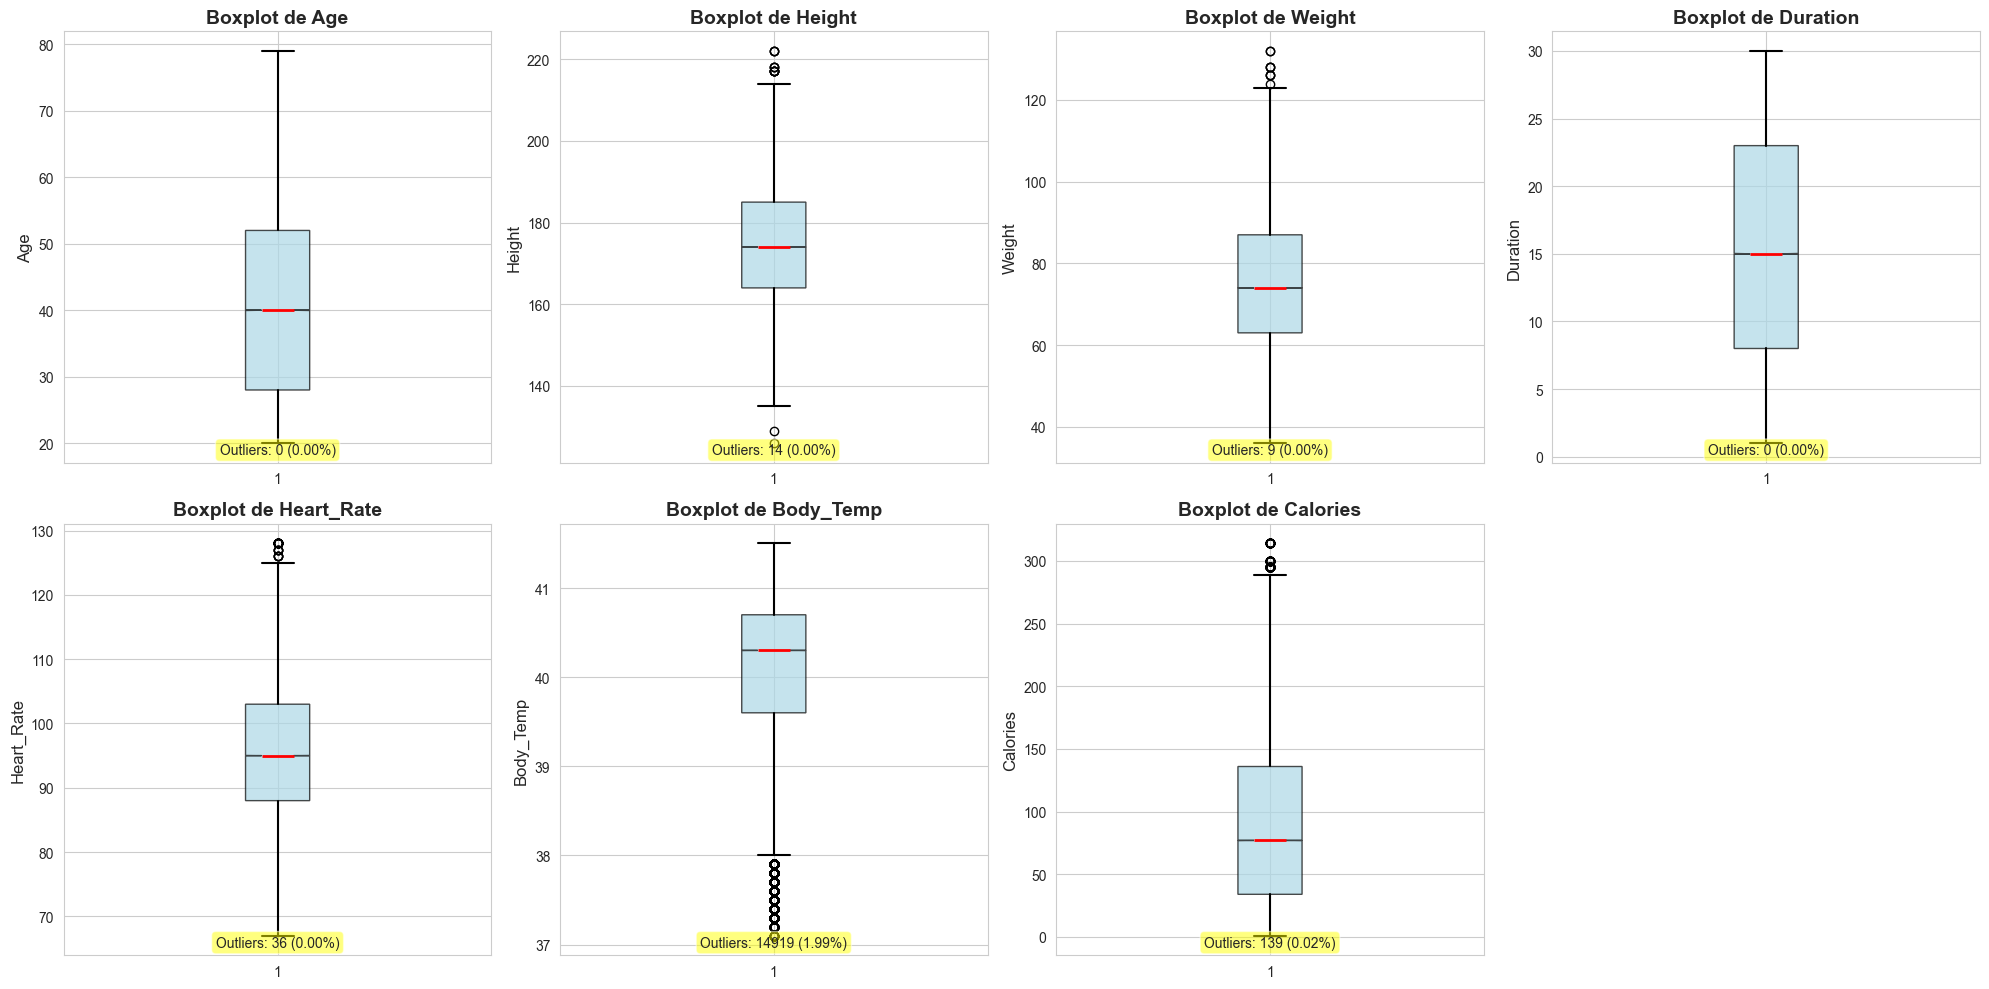

✅ Boxplots guardados en: results/figures/boxplots_outliers.png


In [3]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]

    # Boxplot con puntos
    bp = ax.boxplot(_df[col], vert=True, patch_artist=True, notch=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))

    # Título
    ax.set_title(f'Boxplot de {col}', fontsize=14, fontweight='bold')
    ax.set_ylabel(col, fontsize=12)

    # Calcular outliers
    Q1 = _df[col].quantile(0.25)
    Q3 = _df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = _df[(_df[col] < lower_bound) | (_df[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(_df)) * 100

    # Agregar texto con info
    ax.text(0.5, 0.02, f'Outliers: {n_outliers} ({pct_outliers:.2f}%)',
            transform=ax.transAxes, horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Eliminar eje vacío
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('../results/figures/boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Boxplots guardados en: results/figures/boxplots_outliers.png")

Generando pairplot completo (puede tomar varios minutos con 750K registros)...


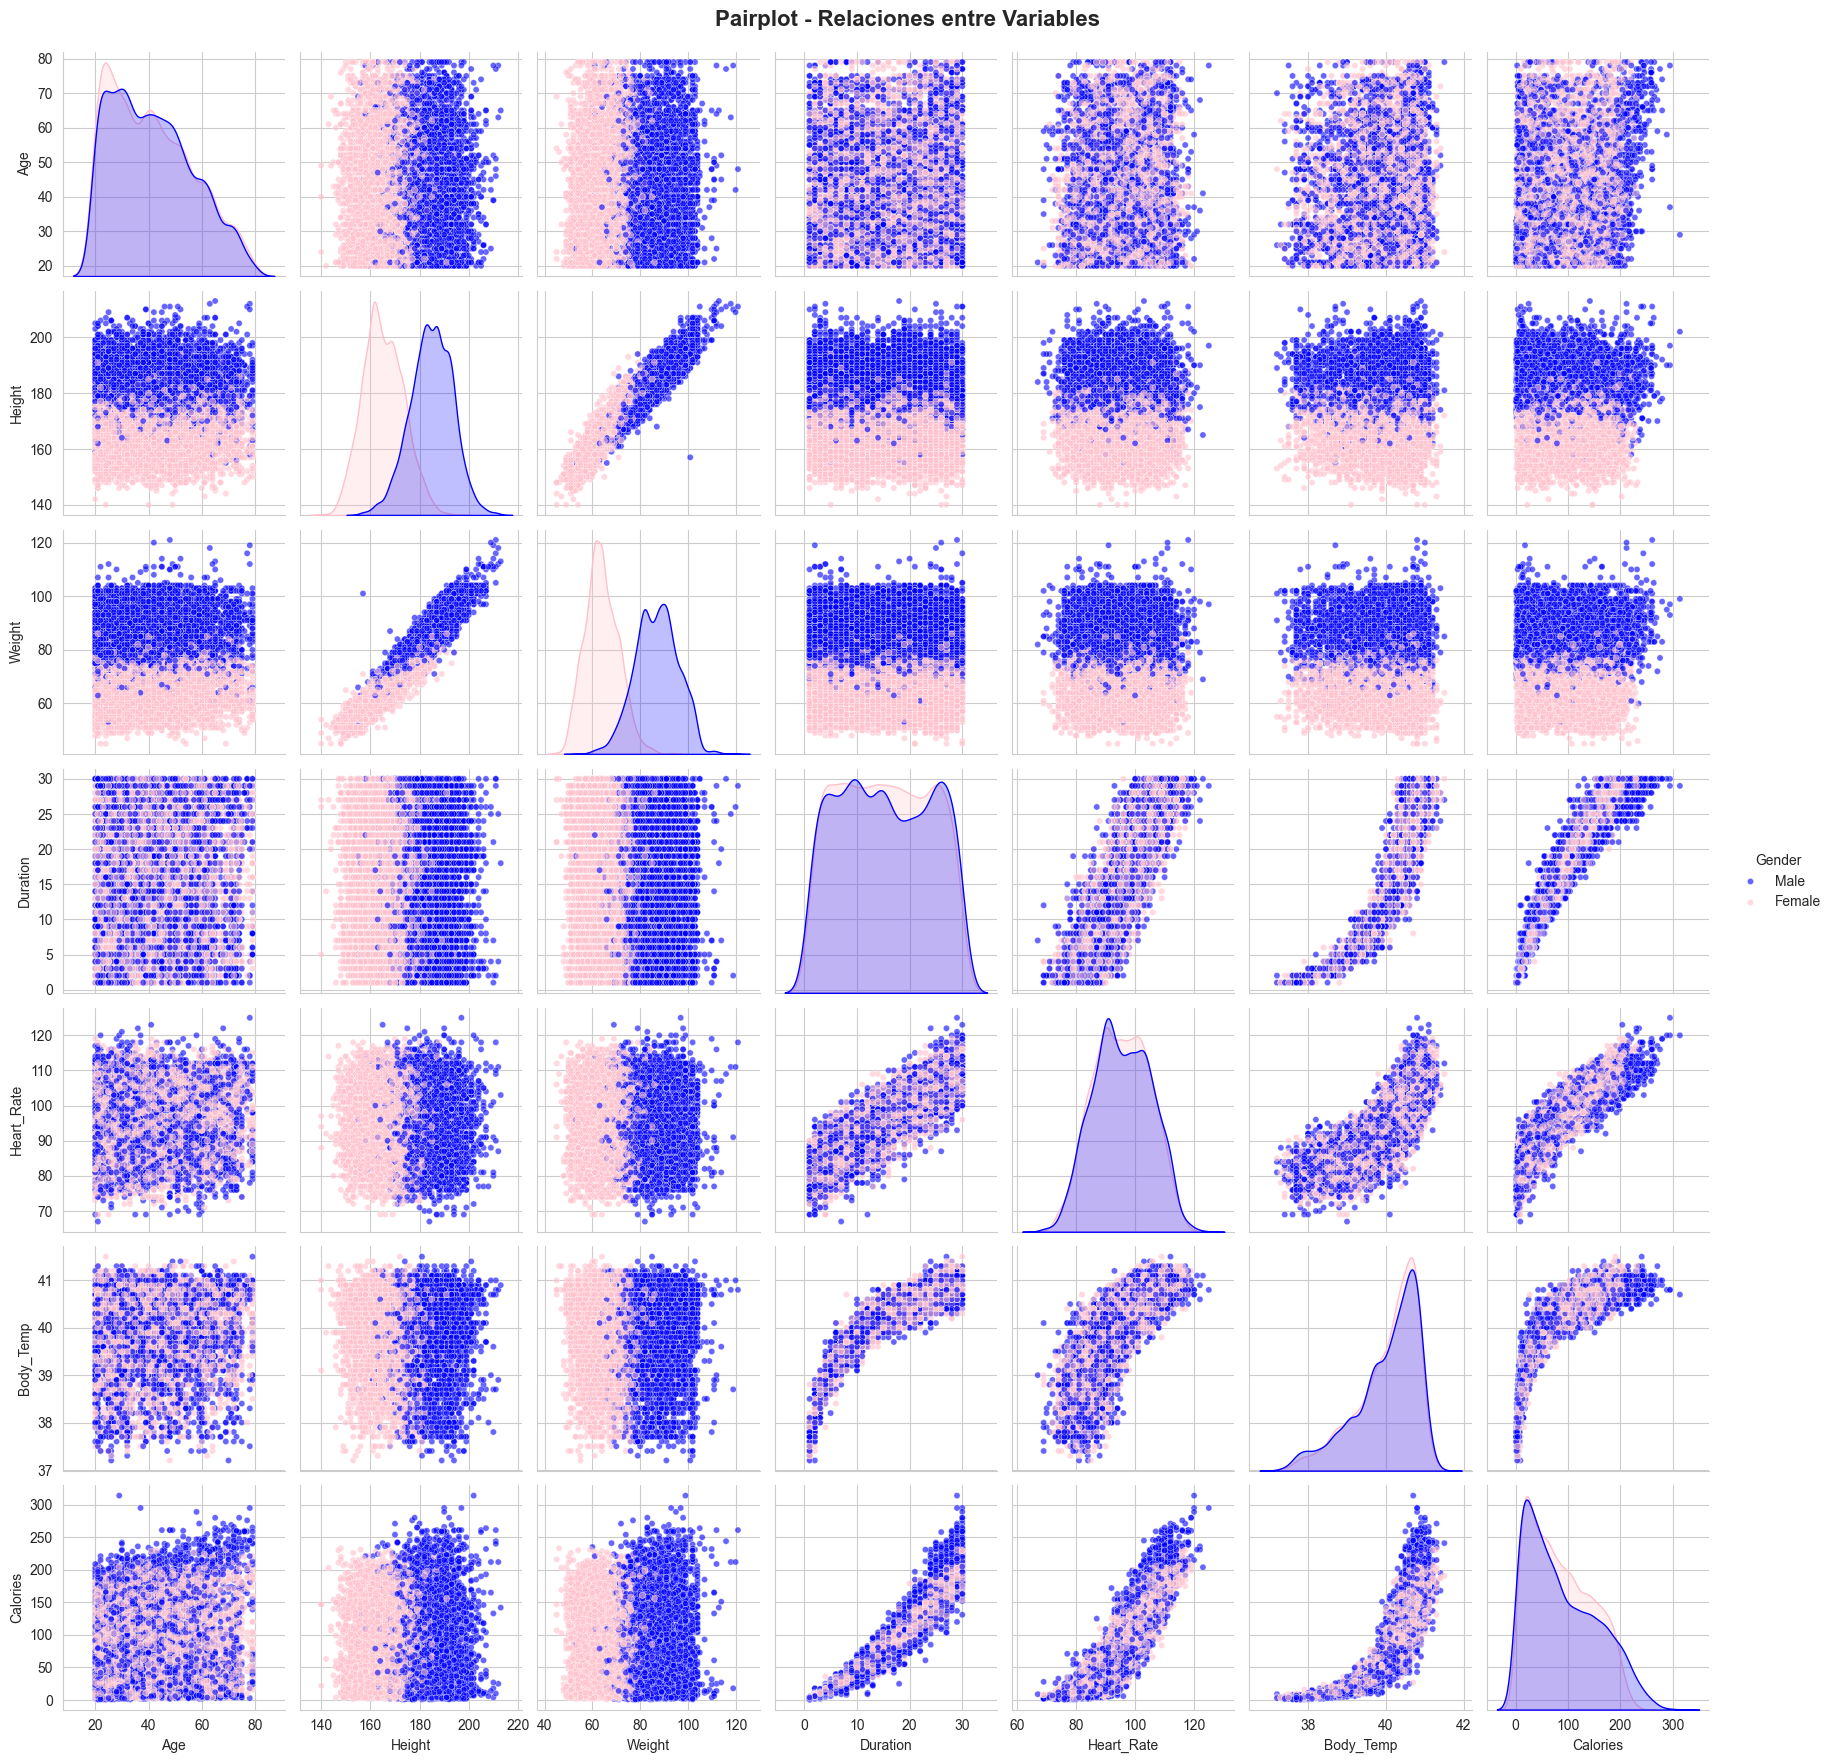

✅ Pairplot guardado en: results/figures/pairplot_completo.png
   (Generado con muestra aleatoria de 10,000 registros para eficiencia)


In [4]:
print("Generando pairplot completo (puede tomar varios minutos con 750K registros)...")

# Para eficiencia, tomar una muestra aleatoria
sample_size = 10000
_df_sample = _df.sample(n=sample_size, random_state=42)

# Crear pairplot
pairplot_vars = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Agregar columna de género si existe
if 'Sex_male' in _df_sample.columns:
    _df_sample['Gender'] = _df_sample['Sex_male'].map({0: 'Female', 1: 'Male'})
    g = sns.pairplot(_df_sample[pairplot_vars + ['Gender']], hue='Gender',
                     diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20},
                     palette={'Female': 'pink', 'Male': 'blue'})
else:
    g = sns.pairplot(_df_sample[pairplot_vars], diag_kind='kde',
                     plot_kws={'alpha': 0.6, 's': 20})

g.fig.suptitle('Pairplot - Relaciones entre Variables', y=1.01, fontsize=16, fontweight='bold')
plt.savefig('../results/figures/pairplot_completo.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Pairplot guardado en: results/figures/pairplot_completo.png")
print(f"   (Generado con muestra aleatoria de {sample_size:,} registros para eficiencia)")

In [5]:
# Calcular matriz de correlación
corr = _df[numeric_cols].corr()

print("=" * 80)
print("MATRIZ DE CORRELACIONES COMPLETA")
print("=" * 80)
print(corr.round(4))

# Identificar correlaciones altas
print("\n" + "=" * 80)
print("CORRELACIONES MÁS FUERTES CON LA VARIABLE OBJETIVO (CALORIES)")
print("=" * 80)

calories_corr = corr['Calories'].sort_values(ascending=False)
print(calories_corr)

print("\n" + "=" * 80)
print("ANÁLISIS DE CORRELACIONES")
print("=" * 80)

for var, corr_val in calories_corr.items():
    if var != 'Calories':
        print(f"\n{var} vs Calories:")
        print(f"  - Correlación: {corr_val:.4f}")

        if abs(corr_val) > 0.7:
            strength = "MUY FUERTE"
        elif abs(corr_val) > 0.5:
            strength = "FUERTE"
        elif abs(corr_val) > 0.3:
            strength = "MODERADA"
        elif abs(corr_val) > 0.1:
            strength = "DÉBIL"
        else:
            strength = "MUY DÉBIL"

        direction = "POSITIVA" if corr_val > 0 else "NEGATIVA"

        print(f"  - Interpretación: Correlación {strength} {direction}")

        if abs(corr_val) > 0.5:
            print(f"  - ⭐ Variable IMPORTANTE para predicción")

# Identificar multicolinealidad entre predictores
print("\n" + "=" * 80)
print("DETECCIÓN DE MULTICOLINEALIDAD ENTRE PREDICTORES")
print("=" * 80)

high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7 and corr.columns[i] != 'Calories' and corr.columns[j] != 'Calories':
            high_corr_pairs.append({
                'Var1': corr.columns[i],
                'Var2': corr.columns[j],
                'Correlation': corr.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️ Pares de variables con correlación alta (>0.7):")
    for pair in high_corr_pairs:
        print(f"  - {pair['Var1']} vs {pair['Var2']}: {pair['Correlation']:.4f}")
    print("\n  → Considerar eliminar una variable de cada par para evitar multicolinealidad")
else:
    print("\n✅ No se detectó multicolinealidad significativa entre predictores")

# Guardar matriz de correlación
corr.to_csv('../results/correlation_matrix.csv')
print("\n✅ Matriz de correlación guardada en: results/correlation_matrix.csv")

MATRIZ DE CORRELACIONES COMPLETA
               Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
Age         1.0000  0.0120  0.0737    0.0157      0.0170     0.0303    0.1457
Height      0.0120  1.0000  0.9580   -0.0299     -0.0132    -0.0346   -0.0040
Weight      0.0737  0.9580  1.0000   -0.0208     -0.0024    -0.0237    0.0159
Duration    0.0157 -0.0299 -0.0208    1.0000      0.8753     0.9031    0.9599
Heart_Rate  0.0170 -0.0132 -0.0024    0.8753      1.0000     0.7960    0.9087
Body_Temp   0.0303 -0.0346 -0.0237    0.9031      0.7960     1.0000    0.8287
Calories    0.1457 -0.0040  0.0159    0.9599      0.9087     0.8287    1.0000

CORRELACIONES MÁS FUERTES CON LA VARIABLE OBJETIVO (CALORIES)
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64

ANÁLISIS DE CORRELACIONES

Duration vs Calories:
  - Correlación: 0.9599
  - Interpreta

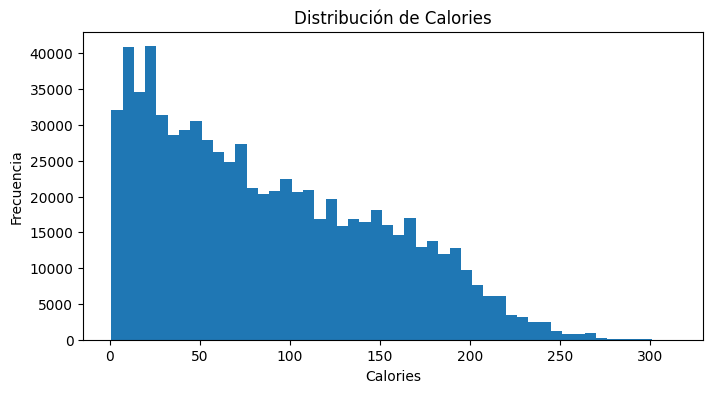

Calories: mean= 88.28278133333333 median= 77.0 std= 62.39534902771433


In [3]:
plt.figure(figsize=(8,4))
plt.hist(_df['Calories'], bins=50)
plt.title('Distribución de Calories')
plt.xlabel('Calories')
plt.ylabel('Frecuencia')
plt.show()

print('Calories: mean=', _df['Calories'].mean(), 'median=', _df['Calories'].median(), 'std=', _df['Calories'].std())


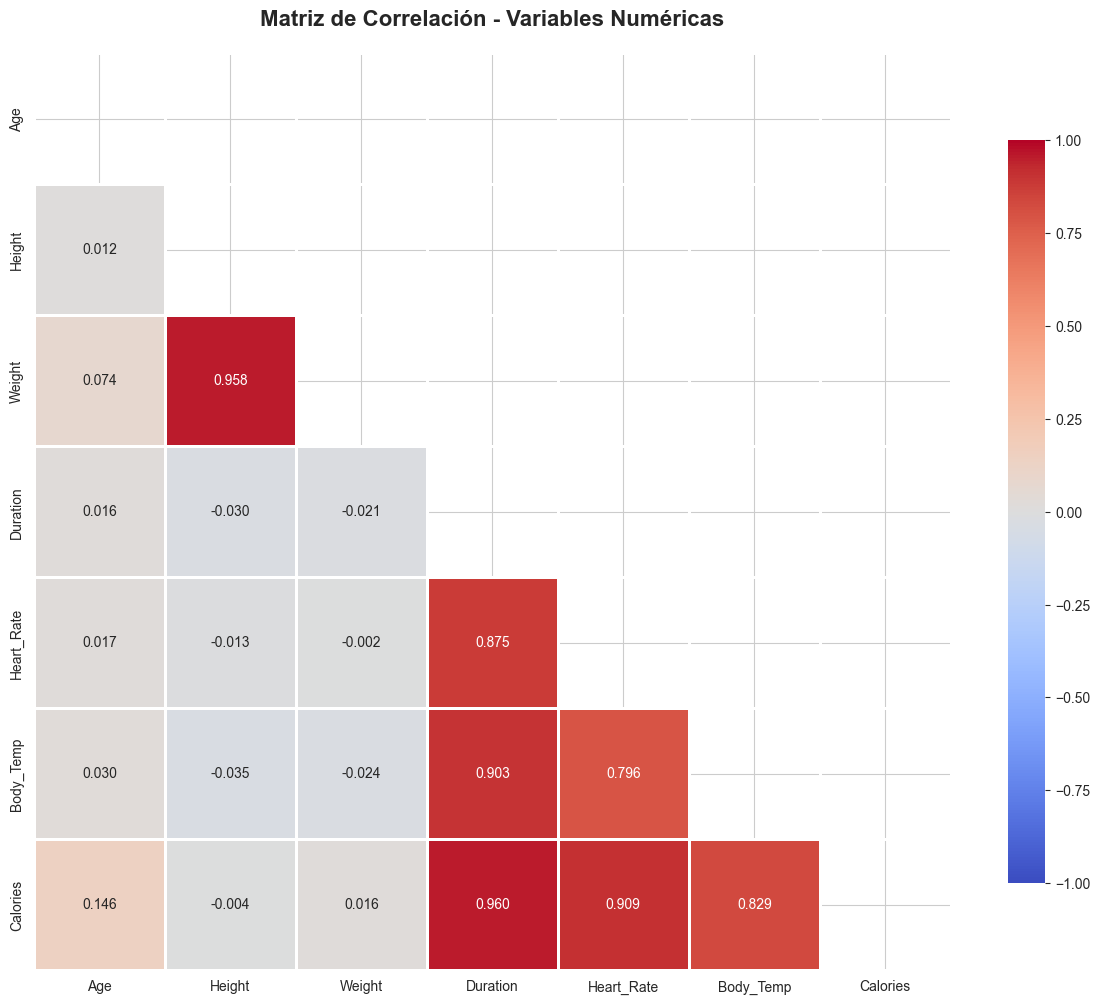

✅ Heatmap de correlación guardado en: results/figures/correlation_heatmap.png


In [6]:
plt.figure(figsize=(12, 10))

# Crear máscara para triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Crear heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap de correlación guardado en: results/figures/correlation_heatmap.png")

PRUEBAS DE NORMALIDAD

Age:
  - Shapiro-Wilk: statistic=0.9503, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.0870, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Height:
  - Shapiro-Wilk: statistic=0.9861, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.0577, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Weight:
  - Shapiro-Wilk: statistic=0.9678, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.0862, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Duration:
  - Shapiro-Wilk: statistic=0.9532, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.0759, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Heart_Rate:
  - Shapiro-Wilk: statistic=0.9902, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.0514, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Body_Temp:
  - Shapiro-Wilk: statistic=0.9113, p-value=0.0000
  - Kolmogorov-Smirnov: statistic=0.1350, p-value=0.0000
  → Distribución NO NORMAL (se rechaza H0)

Calories:
 

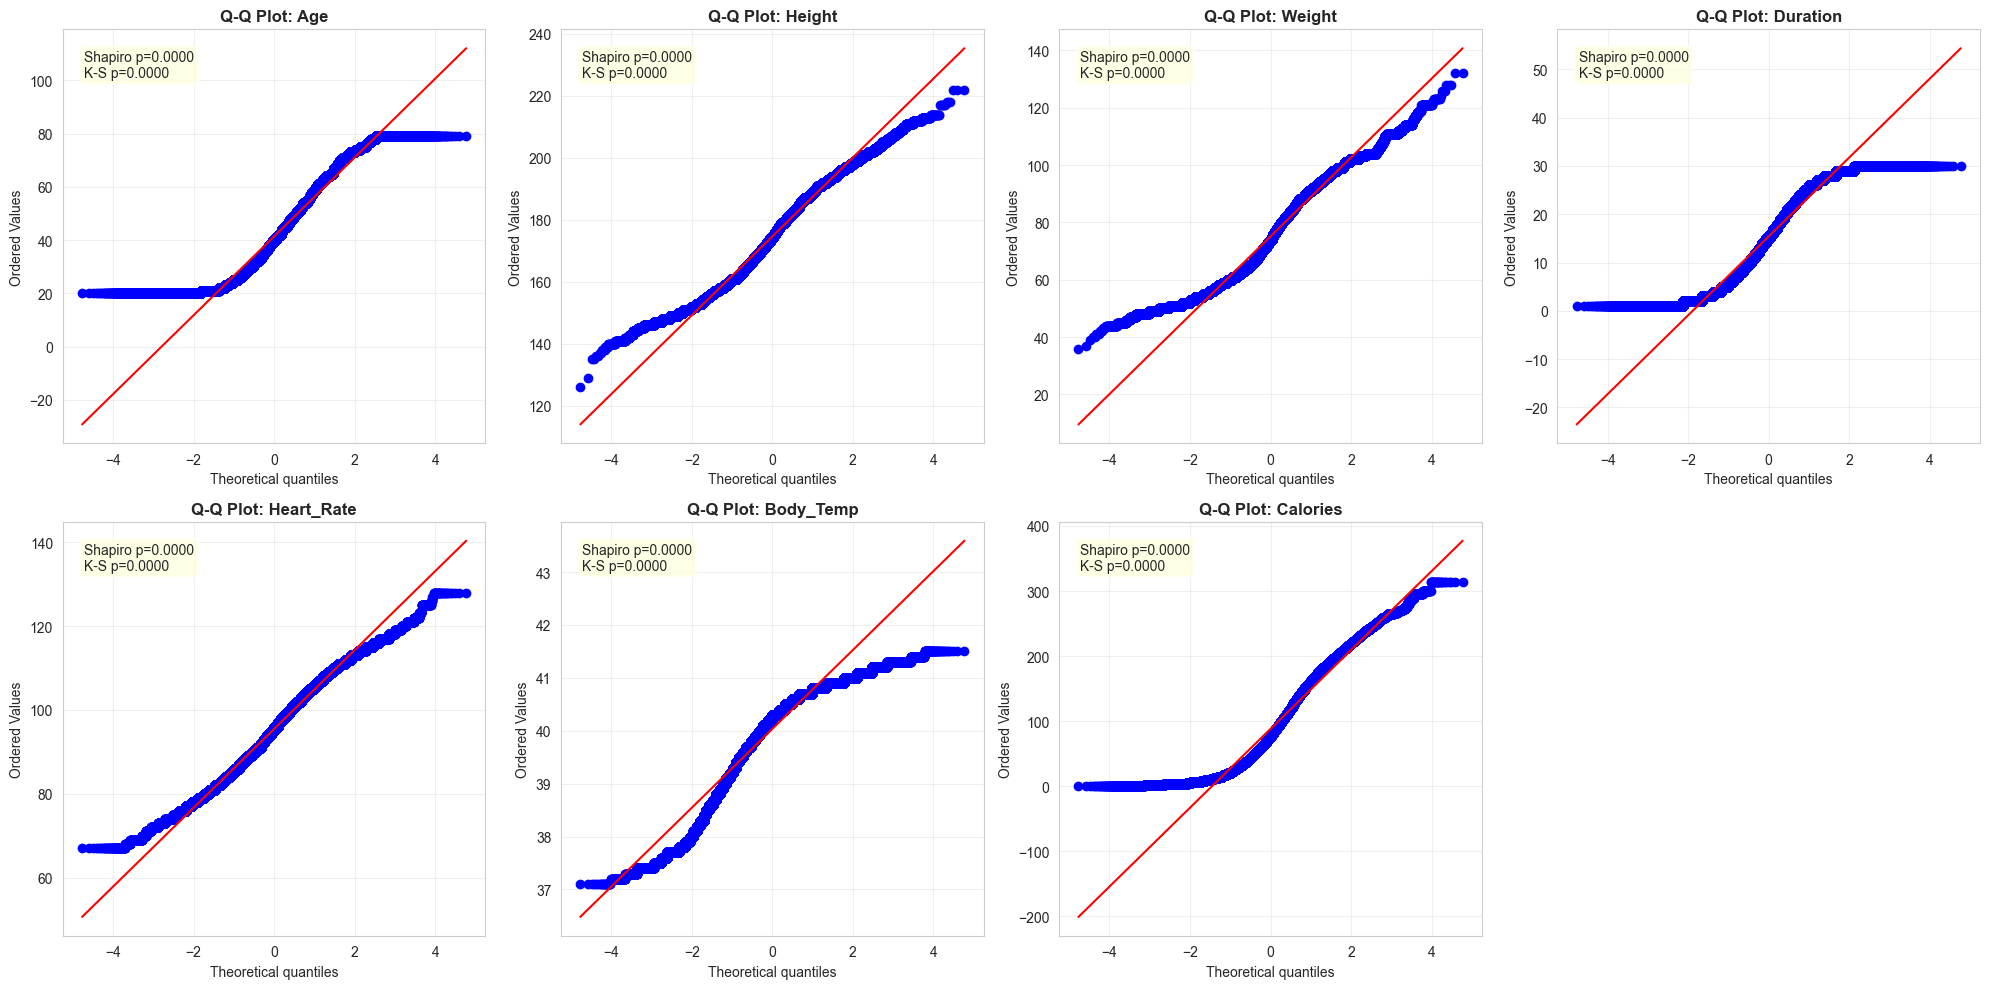


✅ Q-Q Plots guardados en: results/figures/qq_plots_normalidad.png


In [7]:
from scipy import stats

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

print("=" * 80)
print("PRUEBAS DE NORMALIDAD")
print("=" * 80)

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]

    # Q-Q plot
    stats.probplot(_df[col], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {col}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Prueba de Shapiro-Wilk (con muestra para eficiencia)
    sample = _df[col].sample(n=min(5000, len(_df)), random_state=42)
    shapiro_stat, shapiro_p = stats.shapiro(sample)

    # Prueba de Kolmogorov-Smirnov
    ks_stat, ks_p = stats.kstest(_df[col], 'norm', args=(_df[col].mean(), _df[col].std()))

    # Agregar resultados al gráfico
    test_results = f'Shapiro p={shapiro_p:.4f}\nK-S p={ks_p:.4f}'
    ax.text(0.05, 0.95, test_results, transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    # Imprimir resultados
    print(f"\n{col}:")
    print(f"  - Shapiro-Wilk: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
    print(f"  - Kolmogorov-Smirnov: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

    if shapiro_p > 0.05 and ks_p > 0.05:
        print(f"  → Distribución APROXIMADAMENTE NORMAL (no se rechaza H0)")
    else:
        print(f"  → Distribución NO NORMAL (se rechaza H0)")

# Eliminar eje vacío
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('../results/figures/qq_plots_normalidad.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Q-Q Plots guardados en: results/figures/qq_plots_normalidad.png")

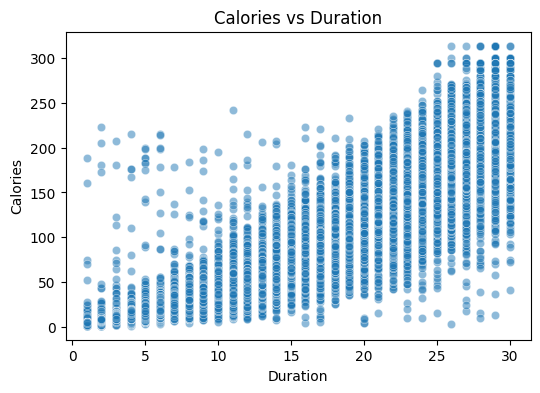

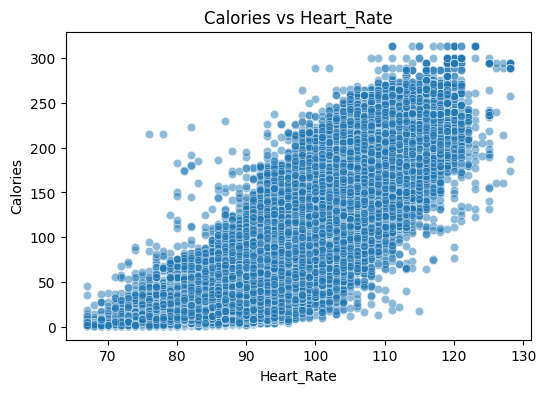

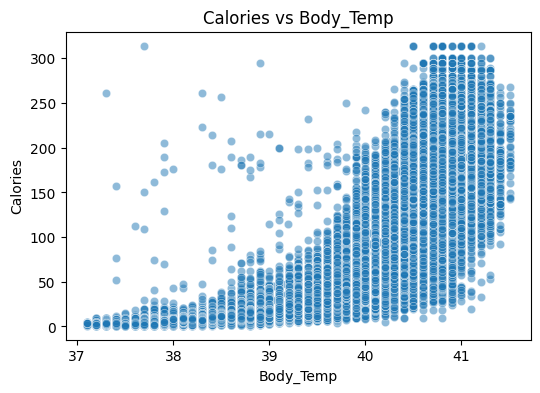

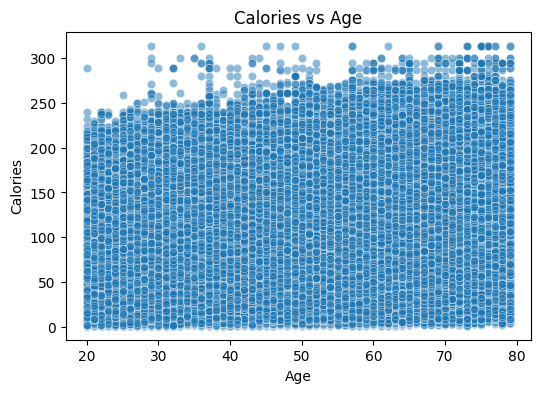

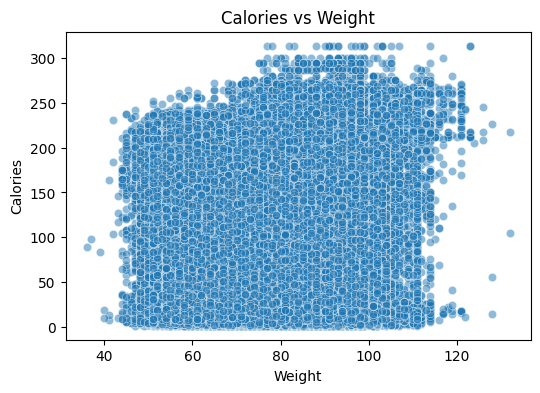

In [5]:
top_feats = corr['Calories'].abs().sort_values(ascending=False).index[1:6].tolist()
for feat in top_feats:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=_df[feat], y=_df['Calories'], alpha=0.5)
    plt.title(f'Calories vs {feat}')
    plt.show()


In [9]:
print("\n" + "=" * 80)
print("INSIGHTS PRINCIPALES DEL ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 80)

print("\n📊 1. CARACTERÍSTICAS GENERALES DEL DATASET:")
print(f"   - Tamaño: {len(_df):,} registros")
print(f"   - Variables: {len(_df.columns)} ({len(numeric_cols)} numéricas + 1 categórica)")
print(f"   - Calidad: Excelente (0% valores nulos, sin duplicados)")
print(f"   - Balance de género: ~50% Female / ~50% Male")

print("\n🎯 2. VARIABLE OBJETIVO (CALORIES):")
calories_stats = _df['Calories'].describe()
print(f"   - Rango: {calories_stats['min']:.1f} - {calories_stats['max']:.1f} calorías")
print(f"   - Media: {calories_stats['mean']:.1f} cal")
print(f"   - Mediana: {calories_stats['50%']:.1f} cal")
print(f"   - Desviación estándar: {calories_stats['std']:.1f} cal")
print(f"   - Asimetría: {_df['Calories'].skew():.2f} (distribución sesgada a la derecha)")
print(f"   - Interpretación: Mayor concentración de valores bajos de calorías")

print("\n🔗 3. CORRELACIONES MÁS IMPORTANTES:")
calories_corr = corr['Calories'].sort_values(ascending=False)
top_3_corr = calories_corr[calories_corr.index != 'Calories'].head(3)
for var, corr_val in top_3_corr.items():
    print(f"   - {var}: {corr_val:.4f} (correlación {'fuerte' if abs(corr_val) > 0.5 else 'moderada'})")

print("\n📈 4. DISTRIBUCIONES DE VARIABLES:")
print("   Variables aproximadamente normales:")
normal_vars = []
non_normal_vars = []
for col in numeric_cols:
    sample = _df[col].sample(n=min(5000, len(_df)), random_state=42)
    _, p_value = stats.shapiro(sample)
    if p_value > 0.05:
        normal_vars.append(col)
    else:
        non_normal_vars.append(col)

if normal_vars:
    print(f"   - {', '.join(normal_vars)}")
else:
    print("   - Ninguna variable sigue distribución perfectamente normal")

print(f"\n   Variables con distribuciones NO normales:")
print(f"   - {', '.join(non_normal_vars)}")
print(f"   → Considerar transformaciones para algunos modelos que requieren normalidad")

print("\n⚠️ 5. OUTLIERS DETECTADOS:")
total_outliers = 0
for col in numeric_cols:
    Q1 = _df[col].quantile(0.25)
    Q3 = _df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = len(_df[(_df[col] < lower) | (_df[col] > upper)])
    pct_out = (n_out / len(_df)) * 100
    total_outliers += n_out
    if pct_out > 1:
        print(f"   - {col}: {n_out:,} outliers ({pct_out:.2f}%)")

if total_outliers == 0:
    print("   - No se detectaron outliers significativos")

print("\n🧠 6. MULTICOLINEALIDAD:")
if high_corr_pairs:
    print(f"   ⚠️ Detectadas {len(high_corr_pairs)} pares de variables con alta correlación")
    print(f"   → Considerar feature selection o regularización")
else:
    print("   ✅ No se detectó multicolinealidad significativa entre predictores")

print("\n✨ 7. RECOMENDACIONES PARA MODELADO:")
print("   1. Dataset listo para Machine Learning (alta calidad)")
print("   2. Considerar modelos no lineales (relaciones no perfectamente lineales)")
print("   3. Las variables más importantes son: " + ', '.join(top_3_corr.index.tolist()))
print("   4. No se requiere imputación de valores faltantes")
print("   5. Evaluar feature engineering con interacciones entre variables")
print("   6. Considerar normalización/estandarización de features")
print("   7. Dataset balanceado por género - no requiere estratificación especial")

print("\n" + "=" * 80)
print("FIN DEL ANÁLISIS EXPLORATORIO")
print("=" * 80)


INSIGHTS PRINCIPALES DEL ANÁLISIS EXPLORATORIO DE DATOS

📊 1. CARACTERÍSTICAS GENERALES DEL DATASET:
   - Tamaño: 750,000 registros
   - Variables: 9 (7 numéricas + 1 categórica)
   - Calidad: Excelente (0% valores nulos, sin duplicados)
   - Balance de género: ~50% Female / ~50% Male

🎯 2. VARIABLE OBJETIVO (CALORIES):
   - Rango: 1.0 - 314.0 calorías
   - Media: 88.3 cal
   - Mediana: 77.0 cal
   - Desviación estándar: 62.4 cal
   - Asimetría: 0.54 (distribución sesgada a la derecha)
   - Interpretación: Mayor concentración de valores bajos de calorías

🔗 3. CORRELACIONES MÁS IMPORTANTES:
   - Duration: 0.9599 (correlación fuerte)
   - Heart_Rate: 0.9087 (correlación fuerte)
   - Body_Temp: 0.8287 (correlación fuerte)

📈 4. DISTRIBUCIONES DE VARIABLES:
   Variables aproximadamente normales:
   - Ninguna variable sigue distribución perfectamente normal

   Variables con distribuciones NO normales:
   - Age, Height, Weight, Duration, Heart_Rate, Body_Temp, Calories
   → Considerar tra